# Sección eficaz elástica $α+^{12}$C

## Librerias

In [1]:
import matplotlib.pyplot as plt
from mpmath import *
import numpy as np
from scipy.special import legendre
from scipy import linalg as lg
import time
import matplotlib as mpl

# Clase

In [2]:
class Proyectil(object):
  def __init__(self, A, Z, E):
    self.A = A
    self.Z = Z
    self.E = E

class Blanco(object):
  def __init__(self, A, Z):
    self.A = A
    self.Z = Z

class Interaccion():
  def __init__(self, Blanco, Proyectil, n, a, parametros):
    self.Blanco = Blanco
    self.Proyectil = Proyectil
    self.parametros = parametros
    self.n = n
    self.a = a      # radio donde el potencial nuclear se desvanece
    self.Cte = 20.736 * (self.Proyectil.A+self.Blanco.A) / (self.Proyectil.A*self.Blanco.A) # C=(hbar**2)/(2*m)  # es una aproximación # K=6e^2 donde e^2=1.44 MeV fm

    self.E = self.Proyectil.E * self.Blanco.A / (self.Proyectil.A+self.Blanco.A)  #conersión de energía del laboratio al entro de masa
    self.k = np.sqrt(self.E/self.Cte)
    
    self.eta  = (self.Proyectil.Z*self.Blanco.Z*1.44) / (2*self.Cte*self.k)
    self.lmax = int(self.a*self.k) 

    # self.barrera = (self.Proyectil.Z*self.Blanco.Z*1.44)/(1.3*(self.Proyectil.A**(1/3)+self.Blanco.A**(1/3)))

    [X,W] = np.polynomial.legendre.leggauss(self.n) #Se guarda los ceros en X[i] y los pesos en W[i] # Estan entre (-1,1)
    self.W = W
    self.X = [(X[i]+1)/2 for i in range(self.n)]

    # ----- creanto listas y matrices -----------
    self.T = [[0]*self.n for i in range (self.n)]
    self.V = [[0]*self.n for i in range (self.n)]
    self.C = [[0]*self.n for i in range (self.n)]
    self.S = [0]*self.lmax

  def U(self, r): #potencial
    V, R, a, W, Rp, ap, Rc = self.parametros 
    R, Rp, Rc = R * self.Blanco.A**(1/3), Rp * self.Blanco.A**(1/3), Rc * self.Blanco.A**(1/3) 
    return  self.Vc(r,Rc) - V*self.f(r,R,a) - W*1j*self.f(r,Rp,ap)

  def f(self,r,R,a):  return (1+np.exp((r-R)/a))**(-1)  # wood saxon

  def Vc(self,r,Rc):
    K = self.Blanco.Z * self.Proyectil.Z * 1.44           # K=6e^2 donde e^2=1.44 MeV fm
    if r<Rc:  return K*(3*Rc**2-r**2) / (2*Rc**3) #K/Rc
    else:     return K/r

  def sigma(self,l):
    U = mp.gamma(1+l+self.eta*(1j))   #U=mp.gamma(1+l+eta*1j)
    O = np.float64(phase(U))          #O=np.atan2(U.imag,U.real)  #O=atan2(U.imag/U.real) #np.angle
    if O<0:  O = O + 2*np.pi
    return O

  def sigma0(self): return self.sigma(0)
  def P(self,x,n):
    leg = legendre(n)
    return leg(x)

  def funcion(self,x,k):           #Función de Lagrange
      leg = np.polynomial.legendre.Legendre.basis(self.n)
      return (-1)**(self.n+k+1) * (x/(self.a*self.X[k])) * np.sqrt(self.a*self.X[k]*(1-self.X[k])) * (leg((2*x/self.a)-1)/(x-self.a*self.X[k]))

  def ruther(self,theta): return ((self.eta/self.k)**2/4) * (1/np.sin(theta/2)**4)
  def fc(self,theta):     return -((self.eta/self.k)/2)*np.exp(2*self.sigma0()*(1j))*(np.exp(-1j*self.eta*np.log(np.sin(theta/2)**2))/np.sin(theta/2)**2)

  def fn(self,x):
      Fn = 0
      for m in range(0,self.lmax):
          Fn = Fn + (2*m+1)*self.P(np.cos(x),m)*np.exp(2*self.sigma(m)*1j)*(self.S[m]-1) 
      return Fn / (2*self.k*1j)

  def seccion(self,theta):   return np.absolute(self.fc(theta) + self.fn(theta))**2

  # -------------- codigo principal ------------
  def Rmatrix(self):
    l = 0 
    for b in range(0,self.lmax): 
      # ---------------------------
        for i in range(0,self.n):
            for m in range(0,self.n):
                if(i==m):
                    self.T[i][m] = (1/self.a**2)*self.Cte*((4*self.n**2+4*self.n+3)*self.X[i]*(1-self.X[i])-6*self.X[i]+1)/(3*self.X[i]**2*(1-self.X[i])**2)
                    
                    self.V[i][m] = self.U(self.X[i]*self.a) + self.Cte*l*(l+1)/((self.X[i]*self.a)**2)
                    self.C[i][m] = self.T[i][m] + self.V[i][m] - self.E
                else:
                    self.T[i][m] = (1/self.a**2) * self.Cte*(((-1)**(i+m)/np.sqrt(self.X[i]*self.X[m]*(1-self.X[i])*(1-
                                    self.X[m]))) * (self.n**2+self.n+1+(self.X[i]+self.X[m]-2*self.X[i]*self.X[m])/((self.X[i]-
                                    self.X[m])**2)-1/(1-self.X[i])-1/(1-self.X[m])))
                    self.V[i][m] = 0
                    self.C[i][m] = self.T[i][m] + self.V[i][m]
        # ---------------------------
        inverse = lg.inv(self.C) #matriz inversa
        
        R = 0
        for g in range(0,self.n):
            for m in range(0,self.n):
                R = R + (self.Cte/self.a)*self.funcion(self.a,g)*inverse[g][m]*self.funcion(self.a,m) #Rmatrix
        
        #------ creando las funciones de Coulomb y sus derivadas  ------------------
        F    = lambda x: coulombf(l,self.eta,x)
        G    = lambda x: coulombg(l,self.eta,x)
        derF = lambda x: diff(F,x)   # 
        derG = lambda x: diff(G,x)
        
        # ---------------
        ka = self.k * self.a
        Hplus  = G(ka)    + j*F(ka)
        Hminus = G(ka)    - j*F(ka)
        Hpder  = derG(ka) + j*derF(ka)
        Hmder  = derG(ka) - j*derF(ka)
        
        self.S[b]   = (Hminus - ka*R*Hmder) / (Hplus - ka*R*Hpder)
        
        l+=1     # numero atómico

  def Seccion(self, theta): return [self.seccion(theta[i]) / self.ruther(theta[i]) for i in range(len(theta))]

## Plot Function

In [3]:
def Plot(theta, y1, title, ylim, parametros, Datos=[]):
  plt.figure(figsize=(10,6)) #Tammaño de la figura
  plt.rcParams.update({'font.size': 14})
  mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10 #mpl.rcParams['xtick.major.width'] = 4
  mpl.rcParams['xtick.minor.size'] = mpl.rcParams['ytick.minor.size'] = 10 #Lineas 3,4,5 modifican el tamaño de las letras

  if len(Datos)!=0: plt.scatter(Datos[:,0], Datos[:,1], marker='o', color='red', label='Experimento',s=15)
  plt.semilogy(degrees(theta), y1, label='Simulación', linewidth=2, color='blue')
  plt.suptitle(title+"\n  $V=$"+str(parametros[0])+", $R=$"+str(parametros[1])+", $a=$"+str(parametros[2])+", $W=$"+str(parametros[3])+
               ", $R'=$"+str(parametros[4])+", $a'=$"+str(parametros[5])+", $R_c=$"+str(parametros[6]), y=1.01)
  plt.yscale("log")
  plt.grid(True)
  plt.legend(title=r'$\bf{Datos}$') #titulo del legend
  plt.ylim(ylim); plt.xlim((0,80))
  plt.xlabel('Angulo ($^\circ$)'); plt.ylabel('Sección Eficaz ')
  plt.show()

### Importando data de drive

In [4]:
from google.colab  import drive
drive.mount('/content/drive')
Datos12C = np.loadtxt('/content/drive/MyDrive/datos.txt')
Datos12C1 = np.loadtxt('/content/drive/MyDrive/datos1.txt')
Datos172Ni = np.loadtxt('/content/drive/MyDrive/DatosNi172.txt')

Mounted at /content/drive


# Resultados

## Carbono 12

### Creando clases y usando R matriz

In [5]:
nucleo12C = Blanco(12,6)  #Carbono 12   
alphaC    = Proyectil(4,2, 139) #(A, Z, E)

parametros = [108.1, 1.22, 0.76, 16.9, 1.85, 0.47, 1.26 ]      #[V, R, a, W, Rp, ap, Rc]
potencial12C = Interaccion(nucleo12C, alphaC, n=50, a=8, parametros=parametros)
potencial12C.Rmatrix()

theta = np.linspace(0.1,np.pi/2,500)
seccion12C = potencial12C.Seccion(theta)

### Grafica

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


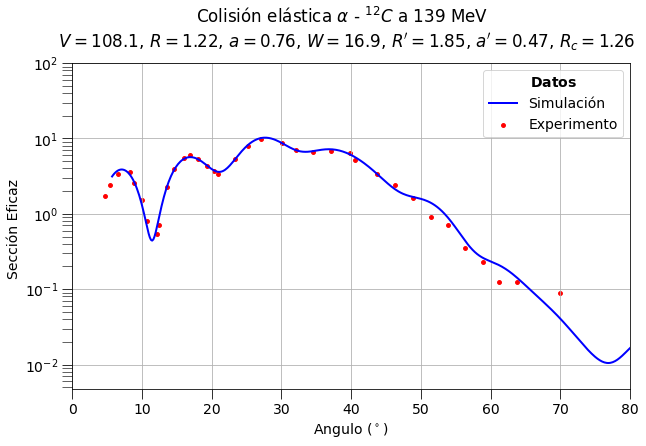

In [6]:
Plot(theta, seccion12C, r'Colisión elástica $\alpha$ - $^{12}C$ a '+str(alphaC.E)+' MeV',(0,100), parametros, Datos12C1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


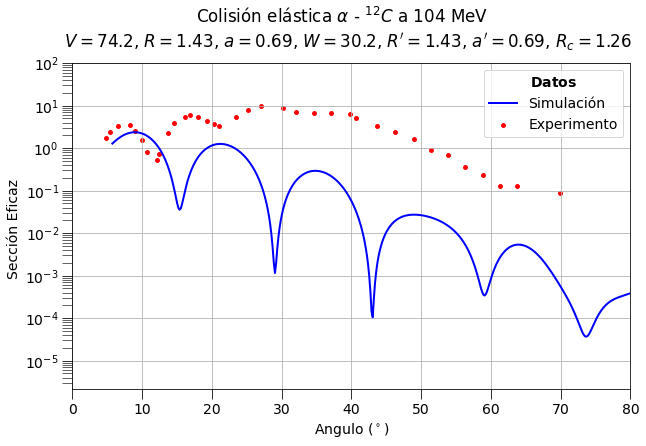

In [14]:
nucleo12C1041 = Blanco(12,6)  #Carbono 12   
alphaC1041    = Proyectil(4,2, 104) #(A, Z, E)

parametrosC1041 = [74.2, 1.43, 0.69, 30.2, 1.43, 0.69, 1.26 ]      #[V, R, a, W, Rp, ap, Rc]
potencial12C1041 = Interaccion(nucleo12C1041, alphaC1041, n=50, a=8, parametros=parametros)
potencial12C1041.Rmatrix()

seccion12C1041 = potencial12C1041.Seccion(theta)
Plot(theta, seccion12C1041, r'Colisión elástica $\alpha$ - $^{12}C$ a '+str(alphaC1041.E)+' MeV',(0,100), parametrosC1041, Datos12C1)

## Niquel 58

### Creando clases y usando R matriz

In [10]:
#%%time
nucleo58Ni = Blanco(58,28)       # (A, Z)
alphaNi      = Proyectil(4,2,172)  #(A, Z, E)

parametrosNi = [116.4, 1.245, 0.793, 20.52, 1.595, 0.571, 1.4]      # [V, R, a, W, Rp, ap, Rc]
potencialNi = Interaccion(nucleo58Ni, alphaNi, n=50, a=15, parametros=parametrosNi)
potencialNi.Rmatrix()

seccion58Ni = potencialNi.Seccion(theta)

### Grafica

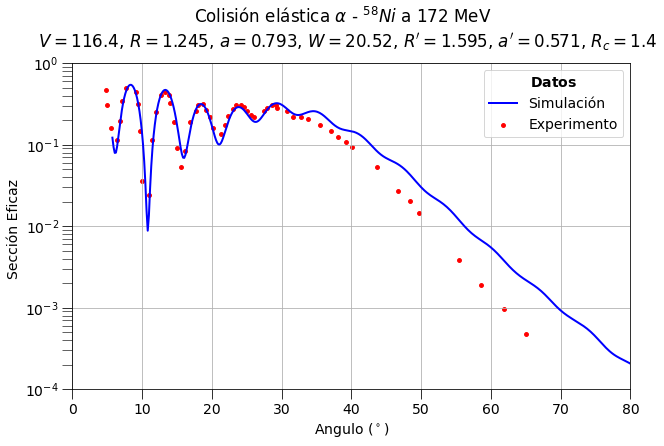

In [15]:
Plot(theta, seccion58Ni, r'Colisión elástica $\alpha$ - $^{58}Ni$ a '+str(alphaNi.E)+' MeV',(0.0001,1),parametrosNi, Datos172Ni)